# Setup

In [1]:
import torch
import numpy as np
import json
import torch.nn as nn
from birdlib import utils

In [2]:
# sudo modprobe nvidia_uvm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
DATASET_NAME = "dataset"
MODEL_NAME = 'VanillaCNN'
DATASET_VAR = 'augm_final'

In [4]:
DATASET_PATH = f'../segments/{DATASET_NAME}'
TRAIN_PATH = f"{DATASET_PATH}/train"
TEST_PATH = f"{DATASET_PATH}/test"
MODEL_PATH = f'./models/{MODEL_NAME}'

# Load the model

In [5]:
with open(f"./utils/{DATASET_NAME}/dataset_config_{DATASET_VAR}.json") as f:
    dataset_config = json.load(f)

In [6]:
test_loader = utils.get_dataloader(dataset_config, split="test", batch_size=1, shuffle=False)
valid_loader = utils.get_dataloader(dataset_config, split="valid", batch_size=1)


In [7]:
mappings = dataset_config["mappings"]

In [8]:
model_class = utils.load_model_class(MODEL_NAME)
model = model_class(len(mappings))
model.to(device)
saving_path = f'models/{MODEL_NAME}/{DATASET_VAR}/checkpoint_{DATASET_VAR}.pth'
checkpoint = torch.load(saving_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Custom Thresholds Creation

In [9]:
from collections import defaultdict
from sklearn.metrics import f1_score

def calculate_conf_scores(valid_loader, model, mappings):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    
    conf_scores = defaultdict(list)

    with torch.no_grad():
        for mel_spec, _, file_path in valid_loader:
            mel_spec = mel_spec.to(device)

            # Estraggo la specie corretta dal path
            correct_species = file_path[0].split("/")[-2]
            outputs = model(mel_spec)
            probs = torch.sigmoid(outputs)[0].cpu().numpy()

            for i, prob in enumerate(probs):
                species_name = list(mappings.keys())[i]
                is_correct = species_name == correct_species
                conf_scores[species_name].append((prob, is_correct))

    return conf_scores

In [10]:
def compute_best_thresholds(conf_scores, num_thresholds=200, min_thresh=0.01, max_thresh=0.95):
    thresholds = {}

    for species, values in conf_scores.items():
        probs, truths = zip(*values)
        probs = np.array(probs)
        truths = np.array(truths).astype(int)

        best_thresh = 0.15
        best_f1 = 0.0

        for thresh in np.linspace(min_thresh, max_thresh, num_thresholds):
            preds = (probs >= thresh).astype(int)
            f1 = f1_score(truths, preds, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_thresh = thresh

        thresholds[species] = best_thresh
        print(f"📊 {species} -> {best_thresh:.3f}, F1-score: {best_f1:.3f}")

    return thresholds



In [11]:
def compute_distribution_based_thresholds(conf_scores, min_thresh=0.05, max_thresh=0.95):
    thresholds = {}

    for species, values in conf_scores.items():
        probs, truths = zip(*values)
        probs = np.array(probs)
        truths = np.array(truths).astype(int)

        correct_probs = np.array([p for p, t in zip(probs, truths) if t == 1])

        if len(correct_probs) == 0:
            thresholds[species] = 0.2  # fallback
            print(f"⚠️ Specie: {species}, nessuna predizione corretta trovata. Soglia fallback: 0.5")
            continue

        mean_conf = np.mean(probs)
        std_conf = np.std(probs)
        threshold = np.clip(mean_conf - 2 * std_conf, min_thresh, max_thresh)

        thresholds[species] = threshold
        print(f"📊 {species} -> {threshold:.3f}, (mean={mean_conf:.3f}, std={std_conf}), samples: {len(correct_probs)}")

    return thresholds


In [12]:
conf_scores = calculate_conf_scores(valid_loader, model, dataset_config["mappings"])
best_thresholds = compute_best_thresholds(conf_scores)
# best_thresholds = compute_distribution_based_thresholds(conf_scores)

📊 Aeroplane -> 0.053, F1-score: 0.804
📊 Muscicapa striata_Spotted Flycatcher -> 0.865, F1-score: 0.743
📊 Periparus ater_Coal Tit -> 0.950, F1-score: 0.453
📊 Regulus regulus_Goldcrest -> 0.010, F1-score: 0.429
📊 Anthus trivialis_Tree Pipit -> 0.128, F1-score: 0.201
📊 Vegetation -> 0.010, F1-score: 0.595
📊 Troglodytes troglodytes_Eurasian Wren -> 0.851, F1-score: 0.372
📊 Erithacus rubecula_European Robin -> 0.936, F1-score: 0.440
📊 None -> 0.019, F1-score: 0.346
📊 Parus major_Great Tit -> 0.936, F1-score: 0.245
📊 Certhia familiaris_Eurasian Treecreeper -> 0.917, F1-score: 0.480
📊 Phylloscopus collybita_Common Chiffchaff -> 0.860, F1-score: 0.643
📊 Coccothraustes coccothraustes_Hawfinch -> 0.015, F1-score: 0.051
📊 Wind -> 0.090, F1-score: 0.667
📊 Turdus merula_Eurasian Blackbird -> 0.780, F1-score: 0.324
📊 Loxia curvirostra_Common Crossbill -> 0.015, F1-score: 0.294
📊 Regulus ignicapilla_Common Firecrest -> 0.879, F1-score: 0.851
📊 Sylvia atricapilla_Eurasian Blackcap -> 0.941, F1-score: 

# Test Model

In [13]:
from sklearn.metrics import average_precision_score, precision_recall_fscore_support

def compute_samplewise_mAP(y_true, y_probs):
    """
    Calcola la sample-wise mAP (media delle AP per ogni sample).
    """
    ap_per_sample = []
    for i in range(y_true.shape[0]):
        if np.sum(y_true[i]) == 0:
            continue  # Evita sample senza label positive
        ap = average_precision_score(y_true[i], y_probs[i])
        ap_per_sample.append(ap)
    return np.mean(ap_per_sample)

def compute_classwise_mAP(y_true, y_probs):
    """
    Calcola la class-wise mAP (media delle AP per ogni classe).
    """
    ap_per_class = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) == 0:
            continue  # Evita classi mai presenti
        ap = average_precision_score(y_true[:, i], y_probs[:, i])
        ap_per_class.append(ap)
    return np.mean(ap_per_class)

def compute_f05(y_true, y_pred):
    _, _, f05, _ = precision_recall_fscore_support(
        y_true, y_pred, beta=0.5, average='macro', zero_division=0
    )
    return f05

In [14]:
inverse_mappings = {value: key for key, value in mappings.items()}

In [15]:
import numpy as np
import csv
import os

def test_model(model, dataset_config, test_loader, batch_size=1, thresholds=0.2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n🧬 Advanced testing on: {device}")
    test_pred_segments = {}

    model.eval()
    criterion = nn.BCEWithLogitsLoss()
    class_names = list(dataset_config['mappings'].keys())
    total_loss = 0.0
    all_preds = []
    all_probs = []
    all_labels = []

    use_custom_threshold = isinstance(thresholds, dict)

    with torch.no_grad():
        for mel_spec, labels, file_path in test_loader:
            basename = os.path.splitext(file_path[0].split("/")[-1])[0]
            date, time, segm1, segm2 = basename.split("_")
            audio_name = "_".join([date, time]) + ".WAV"
            segm = "_".join([segm1, segm2])
            test_pred_segments.setdefault(audio_name, {})
            test_pred_segments[audio_name].setdefault(segm, {})

            mel_spec = mel_spec.to(device)
            labels = labels.to(device)

            outputs = model(mel_spec)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)

            if use_custom_threshold:
                batch_preds = torch.zeros_like(probs)
                for i, class_name in enumerate(class_names):
                    thresh = thresholds.get(class_name, 0.5)
                    batch_preds[:, i] = (probs[:, i] > thresh).float()
            else:
                batch_preds = (probs > thresholds).float()

            correct_probs = probs * batch_preds
            conf_scores = {
                inverse_mappings[i]: correct_probs[0, i].item()
                for i in range(correct_probs.size(1))
                if correct_probs[0, i].item() != 0
            }
            test_pred_segments[audio_name][segm].update(conf_scores)

            all_probs.append(probs.cpu())
            all_preds.append(batch_preds.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(test_loader)
    all_probs = torch.cat(all_probs).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    samplewise_map = compute_samplewise_mAP(all_labels, all_probs)  # chiamata mAP
    classwise_map = compute_classwise_mAP(all_labels, all_probs)    # chiamata cmAP
    f05_score = compute_f05(all_labels, all_preds)

    with open(f"models/{MODEL_NAME}/{DATASET_VAR}/metrics_output.csv", mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Metric", "Value"])
        writer.writerow(["mAP (sample-wise)", samplewise_map])
        writer.writerow(["cmAP (class-wise)", classwise_map])
        writer.writerow(["F0.5 Score", f05_score])

    import gc
    del test_loader
    gc.collect()
    torch.cuda.empty_cache()

    return avg_loss, all_labels, all_preds, all_probs, test_pred_segments

In [16]:

avg_loss, all_labels, all_preds, all_probs, test_pred_segments = test_model(model, dataset_config, test_loader, thresholds=best_thresholds)


🧬 Advanced testing on: cuda


In [30]:
test_pred_segments

{'20190601_080000.WAV': {'519_0': {'Phylloscopus collybita_Common Chiffchaff': 0.9541921019554138},
  '505_5': {},
  '514_5': {'None': 0.027664126828312874},
  '516_0': {},
  '517_5': {'Phylloscopus collybita_Common Chiffchaff': 0.9998063445091248,
   'Sylvia atricapilla_Eurasian Blackcap': 0.9701151251792908,
   'Fringilla coelebs_Common Chaffinch': 0.9977660179138184},
  '520_5': {'Fringilla coelebs_Common Chaffinch': 0.9409430623054504},
  '523_5': {'Sylvia atricapilla_Eurasian Blackcap': 0.9739645719528198},
  '526_5': {'Aeroplane': 0.07306777685880661,
   'Fringilla coelebs_Common Chaffinch': 0.9902220964431763},
  '504_0': {'Fringilla coelebs_Common Chaffinch': 0.990584135055542},
  '513_0': {'None': 0.2685197591781616,
   'Fringilla coelebs_Common Chaffinch': 0.9267092943191528},
  '499_5': {'Erithacus rubecula_European Robin': 0.9999895095825195,
   'Fringilla coelebs_Common Chaffinch': 0.9999532699584961},
  '507_0': {'Sylvia atricapilla_Eurasian Blackcap': 0.9966239929199219,

In [38]:
with open(f'/home/giacomoschiavo/finetuning-BirdNET/utils/{DATASET_NAME}/true_segments_test.json') as f:
    true_segments_test = json.load(f)

In [37]:
with open(f'/home/giacomoschiavo/finetuning-BirdNET/utils/{DATASET_NAME}/true_segments_train.json') as f:
    true_segments = json.load(f)

In [39]:
true_segments.update(true_segments_test)

In [17]:
# WHERE "NONE" REMOVE ALL THE OTHERS
none_index = mappings["None"]
# all indices where preds[none_index] == 1
mask = (all_preds[:, none_index] == 1)
all_preds[mask] = 0
all_preds[mask, none_index] = 1

In [18]:
torch.cuda.empty_cache()

In [19]:
from sklearn.metrics import classification_report

class_names = list(dataset_config['mappings'].keys())
clf_report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True, zero_division=0)

In [20]:
os.makedirs(f"{MODEL_PATH}/{DATASET_VAR}", exist_ok=True)
with open(f"{MODEL_PATH}/{DATASET_VAR}/test_pred_segments.json", "w") as f:
    json.dump(test_pred_segments, f)

In [29]:
from io import StringIO
import pandas as pd

clf_report_df = pd.read_json(StringIO(json.dumps(clf_report)), orient="index")
clf_report_df.sort_index()

,precision,recall,f1-score,support
Aeroplane,0.142857,0.045455,0.068966,22
Anthus trivialis_Tree Pipit,0.928571,0.816754,0.869081,191
Certhia familiaris_Eurasian Treecreeper,0.857143,0.545455,0.666667,110
Coccothraustes coccothraustes_Hawfinch,0.000000,0.000000,0.000000,87
Erithacus rubecula_European Robin,0.765000,0.221739,0.343820,690
Fringilla coelebs_Common Chaffinch,0.528530,0.585195,0.555421,1567
Lophophanes cristatus_Crested Tit,0.000000,0.000000,0.000000,23
Loxia curvirostra_Common Crossbill,0.281250,0.500000,0.360000,36
Muscicapa striata_Spotted Flycatcher,0.000000,0.000000,0.000000,173
None,0.794983,0.663250,0.723166,4683


In [22]:
with open(f"{MODEL_PATH}/{DATASET_VAR}/classification_report.json", "w") as f:
    json.dump(clf_report, f)

In [23]:
torch.cuda.empty_cache()

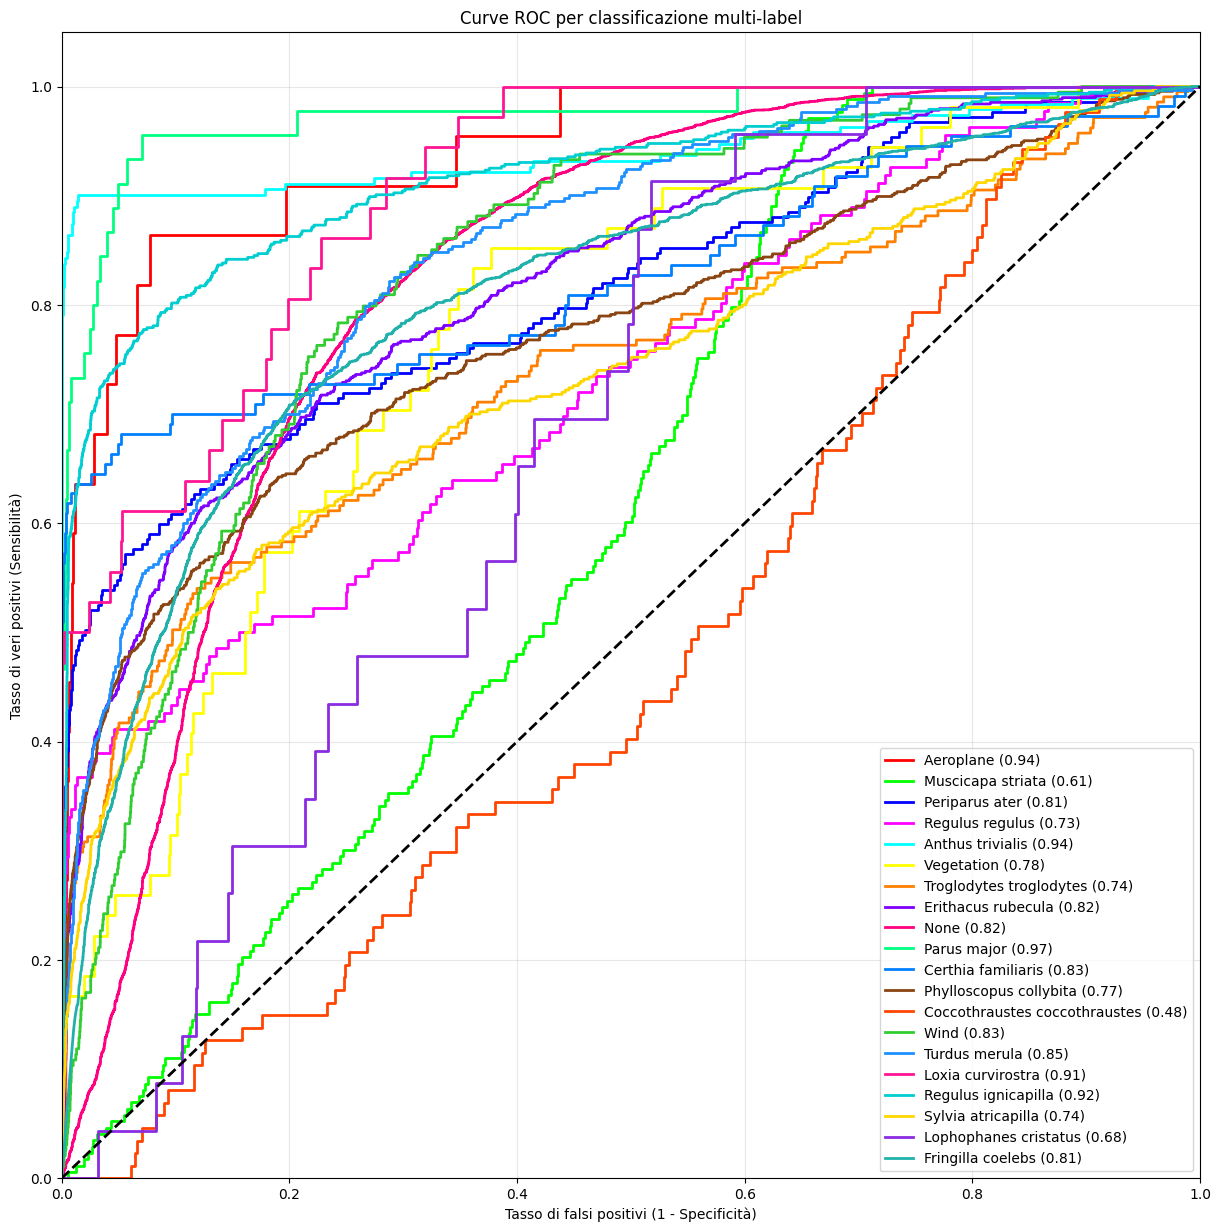

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.colors as mcolors

def plot_roc_curves(y_true, y_pred_proba, class_names=None, selected_classes=None):
    """
    Disegna le curve ROC per ogni classe in un problema di classificazione multi-label.
    
    Parameters:
    -----------
    y_true : array, shape = (n_samples, n_classes)
        Etichette vere in formato one-hot encoding (0 o 1)
    y_pred_proba : array, shape = (n_samples, n_classes)
        Probabilità predette per ogni classe
    class_names : list, optional
        Lista di nomi delle classi (se None, usa indici numerici)
    selected_classes : list, optional
        Lista di indici delle classi da visualizzare (se None, mostra tutte)
    """
    n_classes = y_true.shape[1]
    
    # Se non sono specificate classi selezionate, uso tutte le classi
    if selected_classes is None:
        selected_classes = list(range(n_classes))
    
    # Se non sono specificati nomi delle classi, uso indici numerici
    if class_names is None:
        class_names = [f"classe {i}" for i in range(n_classes)]
    
    # Genero un dizionario di colori fissi per ogni classe
    # Utilizzo 20 colori iniziali e li ripeto se necessario
    bright_colors = [
        '#FF0000',  # Rosso acceso
        '#00FF00',  # Verde lime
        '#0000FF',  # Blu elettrico
        '#FF00FF',  # Magenta
        '#00FFFF',  # Cyan
        '#FFFF00',  # Giallo
        '#FF8000',  # Arancione
        '#8000FF',  # Viola
        '#FF0080',  # Rosa acceso
        '#00FF80',  # Verde acqua
        '#0080FF',  # Azzurro
        '#8B4513',  # Marrone
        '#FF4500',  # Rosso-arancio
        '#32CD32',  # Verde lime scuro
        '#1E90FF',  # Blu dodger
        '#FF1493',  # Rosa profondo
        '#00CED1',  # Turchese scuro
        '#FFD700',  # Oro
        '#8A2BE2',  # Blu viola
        '#20B2AA',  # Verde mare chiaro
        '#FF6347',  # Pomodoro
        '#4169E1',  # Blu reale
        '#9ACD32',  # Giallo verde
        '#BA55D3',  # Orchidea medio
        '#2E8B57',  # Verde mare
        '#D2691E',  # Cioccolato
        '#6A5ACD',  # Blu ardesia
        '#DC143C',  # Cremisi
        '#00FA9A',  # Verde primavera medio
        '#4B0082',  # Indaco
    ]
    
    # Utilizzo la palette personalizzata e, se necessario, aggiungo altri colori da TABLEAU
    if n_classes > len(bright_colors):
        additional_colors = list(mcolors.TABLEAU_COLORS)
        all_colors = bright_colors + additional_colors
    else:
        all_colors = bright_colors
        
    color_dict = {i: all_colors[i % len(all_colors)] for i in range(n_classes)}
    
    # Preparo il grafico
    plt.figure(figsize=(12, 12))
    
    # Calcolo e disegno le curve ROC solo per le classi selezionate
    for i in selected_classes:
        if i < n_classes:  # Verifico che l'indice sia valido
            fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, color=color_dict[i],
                     label=f'{class_names[i].split("_")[0]} ({roc_auc:.2f})')
    
    # Aggiungo la linea diagonale di riferimento (classificatore casuale)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.tight_layout()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasso di falsi positivi (1 - Specificità)')
    plt.ylabel('Tasso di veri positivi (Sensibilità)')
    plt.title('Curve ROC per classificazione multi-label')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_roc_curves(all_labels, all_probs, class_names=class_names)



In [25]:
np.savez(f'{MODEL_PATH}/{DATASET_VAR}/results.npz', y_true=all_labels, y_pred=all_preds, y_pred_proba=all_probs, class_names=class_names)
